In [1]:
import warnings
from osgeo import gdal
from ipywidgets import IntProgress
import glob
import random
import cv2
import numpy as np
import tensorflow as tf
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
%matplotlib inline
import os
from sklearn.model_selection import train_test_split
from PIL import Image
from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization
from tensorflow.keras.layers import UpSampling2D, Input, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers

In [2]:
seed = 42
lr = 1e-4

In [3]:
import os

input_dir = "./data/Data/image256"
target_dir = "./data/Data/mask256"
img_size = (256, 256)
num_classes = 5
batch_size = 64

input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".tif")
    ]
)

target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".tif")
    ]
)

print("Number of image samples:", len(input_img_paths))

print("Number of mask samples:", len(target_img_paths))


Number of image samples: 15762
Number of mask samples: 15762


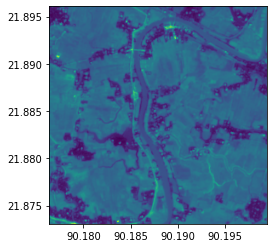

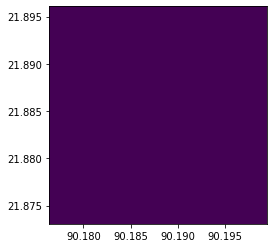

<AxesSubplot:>

In [4]:
#from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img


# # Display input image #7
# display(Image(filename=input_img_paths[9]))

# # Display auto-contrast version of corresponding target (per-pixel categories)
# img = PIL.ImageOps.autocontrast(load_img(target_img_paths[9]))
# display(img)

import rasterio
from rasterio.plot import show

fp = input_img_paths[1005]
img = rasterio.open(fp)
show(img)

fp = target_img_paths[1005]
img = rasterio.open(fp)
show(img)


In [5]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

# Normalize bands into 0.0 - 1.0 scale
def normalize(array):
    diff = array.max() - array.min()
    return (array - array.min()) / diff

def read_image(path):
    raster = rasterio.open(path)
    band_2 = raster.read(1)
    band_3 = raster.read(2)
    band_4 = raster.read(3)
    
    norm_2 = normalize(band_2)
    norm_3 = normalize(band_3)
    norm_4 = normalize(band_4)
    
    x = np.dstack((norm_4, norm_3, norm_2))
    image = np.array(x)
    image = np.array(Image.fromarray((x * 255).astype(np.uint8)).resize((256, 256)).convert('RGB'))
    image[np.isnan(image)] = 0
    image = np.asarray(image, dtype=np.float32)/255.0
    #print("image")
    #print(image.shape)
    #print(image)
    return image

def read_mask(path):
    img = gdal.Open(path)
    x = img.ReadAsArray()
    x = np.array(x)
    x = np.array(Image.fromarray(x.astype(np.uint8)).resize((256, 256)))
    x[np.isnan(x)] = 0
    x = np.expand_dims(x, -1)
    x = to_categorical(x,num_classes=5)
    return x



In [6]:
im = read_mask(target_img_paths[310])

print(im.shape)
print(im)

(256, 256, 5)
[[[0. 0. 0. 0. 1.]
  [0. 0. 0. 0. 1.]
  [0. 0. 0. 0. 1.]
  ...
  [0. 0. 0. 0. 1.]
  [0. 0. 0. 0. 1.]
  [0. 0. 0. 0. 1.]]

 [[0. 0. 0. 0. 1.]
  [0. 0. 0. 0. 1.]
  [0. 0. 0. 0. 1.]
  ...
  [0. 0. 0. 0. 1.]
  [0. 0. 0. 0. 1.]
  [0. 0. 0. 0. 1.]]

 [[0. 0. 0. 0. 1.]
  [0. 0. 0. 0. 1.]
  [0. 0. 0. 0. 1.]
  ...
  [0. 0. 0. 0. 1.]
  [0. 0. 0. 0. 1.]
  [0. 0. 0. 0. 1.]]

 ...

 [[0. 0. 0. 0. 1.]
  [0. 0. 0. 0. 1.]
  [0. 0. 0. 0. 1.]
  ...
  [0. 0. 0. 0. 1.]
  [0. 0. 0. 0. 1.]
  [0. 0. 0. 0. 1.]]

 [[0. 0. 0. 0. 1.]
  [0. 0. 0. 0. 1.]
  [0. 0. 0. 0. 1.]
  ...
  [0. 0. 0. 0. 1.]
  [0. 0. 0. 0. 1.]
  [0. 0. 0. 0. 1.]]

 [[0. 0. 0. 0. 1.]
  [0. 0. 0. 0. 1.]
  [0. 0. 0. 0. 1.]
  ...
  [0. 0. 0. 0. 1.]
  [0. 0. 0. 0. 1.]
  [0. 0. 0. 0. 1.]]]


In [7]:
im2 = read_image(input_img_paths[310])

print("Shape of the iamges ", im2.shape)
print("Min and Max values of the images : ", im2.max(), im2.min())


Shape of the iamges  (256, 256, 3)
Min and Max values of the images :  1.0 0.0


In [8]:
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img

from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical


class SATDATA(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        
        for j, path in enumerate(batch_input_img_paths):
            #print(path)
            img = read_image(path)
            x[j] = img
            x[j] = np.stack(img)
        y = np.zeros((self.batch_size,) + self.img_size + (5,), dtype="uint8")
        
        for j, path in enumerate(batch_target_img_paths):
            y[j] = read_mask(path)
        return x, y

In [9]:
# https://cdn-sv1.deepsense.ai/wp-content/uploads/2017/04/architecture_details.png
# https://deepsense.ai/deep-learning-for-satellite-imagery-via-image-segmentation/

from keras_unet import TF
if TF:
    from tensorflow.keras.models import Model
    from tensorflow.keras.layers import ( 
        BatchNormalization, Conv2D, Conv2DTranspose,
        MaxPooling2D, UpSampling2D, Input,
        concatenate
    )
else:    
    from keras.models import Model
    from keras.layers import ( 
        BatchNormalization, Conv2D, Conv2DTranspose,
        MaxPooling2D, UpSampling2D, Input,
        concatenate
    )


def bn_conv_relu(input, filters, bachnorm_momentum, **conv2d_args):
    x = BatchNormalization(momentum=bachnorm_momentum)(input)
    x = Conv2D(filters, **conv2d_args)(x)
    return x

def bn_upconv_relu(input, filters, bachnorm_momentum, **conv2d_trans_args):
    x = BatchNormalization(momentum=bachnorm_momentum)(input)
    x = Conv2DTranspose(filters, **conv2d_trans_args)(x)
    return x

def satellite_unet(
    input_shape,
    num_classes=5,
    output_activation='sigmoid',
    num_layers=4):

    inputs = Input(input_shape)   
    
    filters = 64
    upconv_filters = 96

    kernel_size = (3,3)
    activation = 'relu'
    strides = (1,1)
    padding = 'same'
    kernel_initializer = 'he_normal'

    conv2d_args = {
        'kernel_size':kernel_size,
        'activation':activation, 
        'strides':strides,
        'padding':padding,
        'kernel_initializer':kernel_initializer
        }

    conv2d_trans_args = {
        'kernel_size':kernel_size,
        'activation':activation, 
        'strides':(2,2),
        'padding':padding,
        'output_padding':(1,1)
        }

    bachnorm_momentum = 0.01

    pool_size = (2,2)
    pool_strides = (2,2)
    pool_padding = 'valid'

    maxpool2d_args = {
        'pool_size':pool_size,
        'strides':pool_strides,
        'padding':pool_padding,
        }
    
    x = Conv2D(filters, **conv2d_args)(inputs)
    c1 = bn_conv_relu(x, filters, bachnorm_momentum, **conv2d_args)    
    x = bn_conv_relu(c1, filters, bachnorm_momentum, **conv2d_args)
    x = MaxPooling2D(**maxpool2d_args)(x)

    down_layers = []

    for l in range(num_layers):
        x = bn_conv_relu(x, filters, bachnorm_momentum, **conv2d_args)
        x = bn_conv_relu(x, filters, bachnorm_momentum, **conv2d_args)
        down_layers.append(x)
        x = bn_conv_relu(x, filters, bachnorm_momentum, **conv2d_args)
        x = MaxPooling2D(**maxpool2d_args)(x)

    x = bn_conv_relu(x, filters, bachnorm_momentum, **conv2d_args)
    x = bn_conv_relu(x, filters, bachnorm_momentum, **conv2d_args)
    x = bn_upconv_relu(x, filters, bachnorm_momentum, **conv2d_trans_args)

    for conv in reversed(down_layers):        
        x = concatenate([x, conv])  
        x = bn_conv_relu(x, upconv_filters, bachnorm_momentum, **conv2d_args)
        x = bn_conv_relu(x, filters, bachnorm_momentum, **conv2d_args)
        x = bn_upconv_relu(x, filters, bachnorm_momentum, **conv2d_trans_args)

    x = concatenate([x, c1])
    x = bn_conv_relu(x, upconv_filters, bachnorm_momentum, **conv2d_args)
    x = bn_conv_relu(x, filters, bachnorm_momentum, **conv2d_args)
           
    outputs = Conv2D(5, kernel_size=(1,1), strides=(1,1), activation=output_activation, padding='valid') (x)   
    
    print("output data")
    print(outputs.shape)
    
    model = Model(inputs=[inputs], outputs=[outputs])
    return model



# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
model = satellite_unet(input_shape=(256, 256, 3))
model.summary()

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------
output data
(None, 256, 256, 5)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________

In [10]:
import random


# Split our img paths into a training and a validation set
val_samples = 3000
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)

train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]

# print(train_input_img_paths[100])
# print(train_target_img_paths[100])

val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

# Instantiate data Sequences for each split
train_gen = SATDATA(batch_size, img_size, train_input_img_paths, train_target_img_paths)
val_gen = SATDATA(batch_size, img_size, val_input_img_paths, val_target_img_paths)

In [11]:
# for batch_idx, (x_batch, y_batch) in enumerate(train_gen):
#     print(x_batch.shape, y_batch.shape)

In [12]:
print(val_gen.__len__())
print(train_gen.__len__())

46
199


In [13]:
valid_len = val_gen.__len__()
train_len = train_gen.__len__()

In [14]:
def iou(y_true, y_pred, smooth = 100):
    print("Inside IOU -->")
    print(y_true.shape)
    print(p_pred.shape)
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    union = K.sum(y_true,-1) + K.sum(y_pred,-1) - intersection
    #sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
    iou_acc = (intersection + smooth) / (union + smooth)
    return iou_acc

In [15]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_multilabel(y_true, y_pred, numLabels=5):
    print("Inside IOU -->")
    print(y_true.shape)
    print(y_pred.shape)
    dice=0
    for index in range(numLabels):
        dice -= dice_coef(y_true[:,index,:,:,:], y_pred[:,index,:,:,:])
    return dice

In [16]:
# epochs = 10

# optimizer = tf.keras.optimizers.Adam(lr)
# loss = tf.keras.losses.CategoricalCrossentropy()
# acc_metric = tf.keras.metrics.CategoricalAccuracy()

# # training loop

# for epoch in range(epochs):
#     print(f"\nStart of training epoch {epoch}") 
#     for batch_idx, (x_batch, y_batch) in enumerate(train_gen):
#         with tf.GradientTape() as tape:
#             #forward pass
#             #print("shape of X : ", x_batch.shape)
#             #print("shape of y : ", y_batch.shape)
            
#             y_pred = model(x_batch, training=True)
            
#             #print("shape of y_pred : ", y_pred.shape)
#             loss = loss(y_batch, y_pred)
        
#         gradients = tape.gradient(loss, model.trainable_weights)
#         optimizer.apply_gradients(zip(gradients, model.trainable_weights))
        
#         acc_metric.update_state(y_batch, y_pred)
        
#     train_acc = acc_metric.result()
#     print(f"Accuracy over epoch {train_acc}")
    
#     acc_metric.reset_state()
    
    

In [17]:
# Configure the model for training.
# We use the "sparse" version of categorical_crossentropy
# because our target data is integers.
from keras.optimizers import Adam, SGD
from keras_unet.metrics import iou, iou_thresholded
#from keras_unet.losses import jaccard_distance

from keras.callbacks import ModelCheckpoint

steps_per_ep = train_len // batch_size

model_filename = 'segm_model_v0.h5'
callback_checkpoint = ModelCheckpoint(
    model_filename, 
    verbose=1, 
    monitor='val_loss', 
    save_best_only=True,
)

# loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=output_layer, labels=labels))   
# opt = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss) 
#tf.keras.metrics.MeanIoU(num_classes=5)


model.compile(optimizer=Adam( lr = 1e-4, decay=1e-5),
              loss='categorical_crossentropy',
              metrics=[iou, 'accuracy']
             )


# Train the model, doing validation at the end of each epoch.
epochs = 15
history = model.fit(train_gen, 
                    epochs=epochs, 
                    steps_per_epoch=steps_per_ep, 
                    validation_data=val_gen, 
                    callbacks=[callback_checkpoint])

Epoch 1/15
3/3 [==============================] - 1667s 749s/step - loss: 2.1698 - iou: 0.1527 - accuracy: 0.1659 - val_loss: 1.9493 - val_iou: 0.1712 - val_accuracy: 0.2291

Epoch 00001: val_loss improved from inf to 1.94928, saving model to segm_model_v0.h5
Epoch 2/15
3/3 [==============================] - 1606s 721s/step - loss: 1.8755 - iou: 0.1758 - accuracy: 0.2430 - val_loss: 1.7730 - val_iou: 0.1925 - val_accuracy: 0.3094

Epoch 00002: val_loss improved from 1.94928 to 1.77302, saving model to segm_model_v0.h5
Epoch 3/15
3/3 [==============================] - 1641s 731s/step - loss: 1.7068 - iou: 0.1928 - accuracy: 0.3158 - val_loss: 1.6322 - val_iou: 0.2109 - val_accuracy: 0.3695

Epoch 00003: val_loss improved from 1.77302 to 1.63223, saving model to segm_model_v0.h5
Epoch 4/15
3/3 [==============================] - 1607s 720s/step - loss: 1.6128 - iou: 0.2082 - accuracy: 0.3670 - val_loss: 1.5642 - val_iou: 0.2250 - val_accuracy: 0.4111

Epoch 00004: val_loss improved from 1